## MARBL diagnostics for ocean history files: 

### JRA-forced MOM6-MARBL - hybrid case, case 44

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
#import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
#from scipy import stats

import utils
import pandas as pd
import pop_tools
#import tools

import matplotlib.colors as colors

### Define case

In [2]:
case = 'g.e23_a17f.GMOMMARBL_JRA.TL319_t232_hycom1_N75.2024.068'
user = 'klindsay'

## Define the year range to examine and get the CESM history files

In [3]:
start_yr = 112
num_years = 10
endyr = start_yr + num_years 

#### first get the 3-D variables

In [4]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 112 !
doing simulation year 113 !
doing simulation year 114 !
doing simulation year 115 !
doing simulation year 116 !
doing simulation year 117 !
doing simulation year 118 !
doing simulation year 119 !
doing simulation year 120 !
doing simulation year 121 !


In [5]:
cesm_mon_ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

#### Now grab the 2-D variables

In [6]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.native.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 112 !
doing simulation year 113 !
doing simulation year 114 !
doing simulation year 115 !
doing simulation year 116 !
doing simulation year 117 !
doing simulation year 118 !
doing simulation year 119 !
doing simulation year 120 !
doing simulation year 121 !


In [7]:
cesm_mon_ds2 = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

### Keep only the variables we need (use this list for both 2-D and 3-D datasets)

In [8]:
variables2d = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','POC_FLUX_100m',
             'x_graze_microzoo_zint','x_graze_mesozoo_zint',
            'IFRAC'] 

variables3d = ['SiO2_PROD','coccoCaCO3','diatC', 'coccoC','spC','diazC','SALT',
             'PO4','Fe','NO3','SiO3','ALK','photoC_TOT_zint_100m',
            'microzooC','mesozooC','diaz_Nfix',
            'spChl','diatChl','diazChl','coccoChl','so'] 


coords = {'x':'yh','y':'xh'}

In [9]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables3d + list(coords.values())
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keepthese])

In [10]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables2d + list(coords.values())
cesm_mon_ds2 = cesm_mon_ds2.drop([v for v in cesm_mon_ds2.variables if v not in keepthese])

## Get the grid data for MOM6

In [11]:
ds_grid = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e23b16.TL319_t232.GIAFMARBL.001.mom6.h.static.nc')

In [12]:
lons = ds_grid.geolon
lats = ds_grid.geolat
area = ds_grid.areacello #m2

#### Make my own dz variable

In [13]:
dz = np.zeros([34])

i = 0

for int in cesm_mon_ds.z_i.values[1:35]:
    
    level_up = cesm_mon_ds.z_i.values[i]
    #print(level_up,int)
    dz[i] = int - level_up

    i = i + 1

dz = xr.DataArray(dz,dims=('z_l'))

### spin up a bit of dask

In [14]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [15]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

<Client: 'tcp://128.117.208.80:42853' processes=0 threads=0, memory=0 B>

### Make the annual mean

In [16]:
cesm_ann_ds = cesm_mon_ds.mean(dim='time', keep_attrs=True).compute()

In [17]:
cesm_ann_ds2 = cesm_mon_ds2.mean(dim='time', keep_attrs=True).compute()

### Turn the monthly ds into a climatology

In [18]:
cesm_mon_ds = cesm_mon_ds.groupby('time.month').mean('time', keep_attrs=True)

In [19]:
cesm_mon_ds2 = cesm_mon_ds2.groupby('time.month').mean('time', keep_attrs=True)

## Compare macronutrients to World Ocean Atlas 2018

In [20]:
depths = cesm_mon_ds.z_l

In [22]:
path = '/glade/work/kristenk/WOA_data'

files = [path+'/woa18_all_n00_01.nc', path+'/woa18_all_p00_01.nc',path+'/woa18_all_i00_01.nc']
ds_woa = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

### Calculate grid cell area on the WOA grid (regular 1° lon/lat)

In [23]:
a = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

j=0

for lat in ds_woa.lat.values:

    pi     =    3.14159265359
    radius = 6378.137
    deg2rad = pi / 180.0
    resolution_lat =1 #res in degrees
    resolution_lon =1 #res in degrees
    elevation = deg2rad * (lat + (resolution_lat / 2.0))
    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat
    a[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    j = j + 1

ds_woa['area']=a

### Surface nutrients

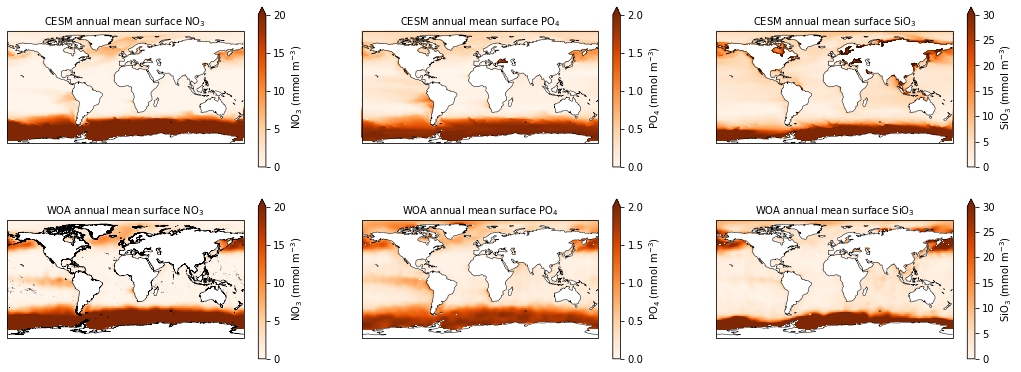

In [24]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
field = cesm_ann_ds.NO3.isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=20, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
field = (ds_woa.n_an.isel(depth=0) * 1.026).squeeze() #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(ds_woa.lon, ds_woa.lat, field, 
                  vmin=0, vmax=20, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

# #---- DIFF panel
# ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
# ax.coastlines('10m',linewidth=0.5)
# ax.set_title('Surface NO$_3$ model bias', fontsize=10)
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  NO3_diff.isel(z_t=0))
# pc3=ax.pcolormesh(lon, lat, 
#                  field, vmin=-10, vmax=10, cmap='bwr',
#                  transform=ccrs.PlateCarree())
# cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
field = cesm_ann_ds.PO4.isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=2, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
field = (ds_woa.p_an.isel(depth=0) * 1.026).squeeze() #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(ds_woa.lon, ds_woa.lat, field, 
                  vmin=0, vmax=2, cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

# #---- DIFF panel
# ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
# ax.coastlines('10m',linewidth=0.5)
# ax.set_title('Surface PO$_4$ bias', fontsize=10)
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  PO4_diff.isel(z_t=0))
# pc3=ax.pcolormesh(lon, lat, 
#                  field, vmin=-1, vmax=1, cmap='bwr',
#                  transform=ccrs.PlateCarree())
# cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
field = cesm_ann_ds.SiO3.isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
field = (ds_woa.i_an.isel(depth=0) * 1.026).squeeze()  #convert from µmol/kg to mmol/m3
pc2=ax.pcolormesh(ds_woa.lon, ds_woa.lat, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                  transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

# #---- DIFF panel
# ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
# ax.coastlines('10m',linewidth=0.5)
# ax.set_title('Surface SiO$_3$ bias', fontsize=10)
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_t=0))
# pc3=ax.pcolormesh(lon, lat, 
#                  field, 
#                   vmin=-15, vmax=15, 
#                   cmap='bwr',
#                  transform=ccrs.PlateCarree())
# cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



### Global nutrient profiles

In [25]:
area_depth = area.where(cesm_ann_ds.ALK > 0)

In [26]:
area_depth_woa = ds_woa.area.where(ds_woa.n_an > 0).squeeze()

In [27]:
ds_glb_nuts = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_l']})
ds_glb_nuts['NO3'] = ((cesm_ann_ds['NO3']*area_depth).sum(dim=('xh','yh'))/(area_depth.sum(dim=('xh','yh')))).compute()
ds_glb_nuts['PO4'] = ((cesm_ann_ds['PO4']*area_depth).sum(dim=('xh','yh'))/(area_depth.sum(dim=('xh','yh')))).compute()
ds_glb_nuts['SiO3'] = ((cesm_ann_ds['SiO3']*area_depth).sum(dim=('xh','yh'))/(area_depth.sum(dim=('xh','yh')))).compute()

In [28]:
ds_glb_woa = xr.Dataset({v: ds_woa[v] for v in ['depth']})
ds_glb_woa['NO3'] = ((ds_woa['n_an']*area_depth_woa).sum(dim=('lon','lat'))/(area_depth_woa.sum(dim=('lon','lat')))).compute()
ds_glb_woa['PO4'] = ((ds_woa['p_an']*area_depth_woa).sum(dim=('lon','lat'))/(area_depth_woa.sum(dim=('lon','lat')))).compute()
ds_glb_woa['SiO3'] = ((ds_woa['i_an']*area_depth_woa).sum(dim=('lon','lat'))/(area_depth_woa.sum(dim=('lon','lat')))).compute()

In [29]:
ds_glb_woa = ds_glb_woa.squeeze()

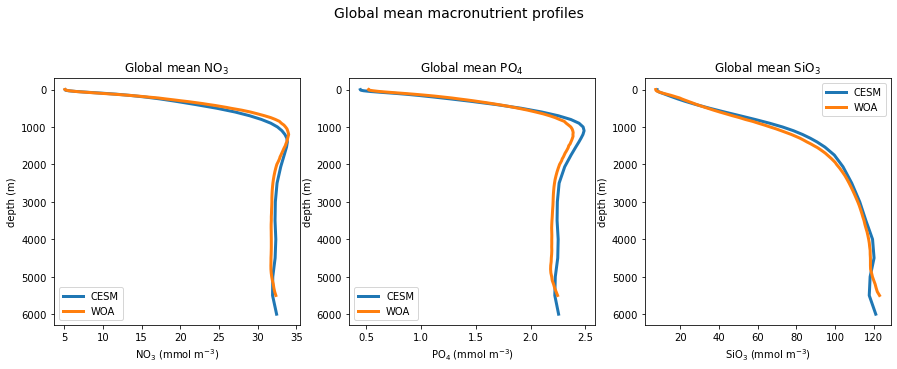

In [30]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb_nuts['NO3'], depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, ds_glb_woa.depth, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb_nuts['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, ds_glb_woa.depth, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb_nuts['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, ds_glb_woa.depth, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


# #COLUMN 1  - NO3 diff

# ax = fig.add_subplot(2,3,4)
# ax.plot(ds_glb_nuts['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
# ax.legend()
# ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
# plt.gca().invert_yaxis()

# #COLUMN 2  - PO4 diff

# ax = fig.add_subplot(2,3,5)
# ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
# ax.legend()
# ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
# plt.gca().invert_yaxis()

# #COLUMN 3  - SiO3 diff

# ax = fig.add_subplot(2,3,6)
# ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
# ax.legend()
# ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
# plt.gca().invert_yaxis()



### Phytoplankton nutrient limitation at surface

In [31]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_ann_ds2.sp_P_lim_surf, cesm_ann_ds2.sp_Fe_lim_surf,cesm_ann_ds2.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_ann_ds2.diat_P_lim_surf, cesm_ann_ds2.diat_Fe_lim_surf, cesm_ann_ds2.diat_N_lim_surf, cesm_ann_ds2.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_ann_ds2.diaz_P_lim_surf, cesm_ann_ds2.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_ann_ds2.cocco_P_lim_surf, cesm_ann_ds2.cocco_Fe_lim_surf, cesm_ann_ds2.cocco_N_lim_surf, cesm_ann_ds2.cocco_C_lim_surf),dim='nutrient')

In [32]:
most_lim_sp = limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat = limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz = limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco = limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(cesm_ann_ds2.sp_N_lim_surf.squeeze())

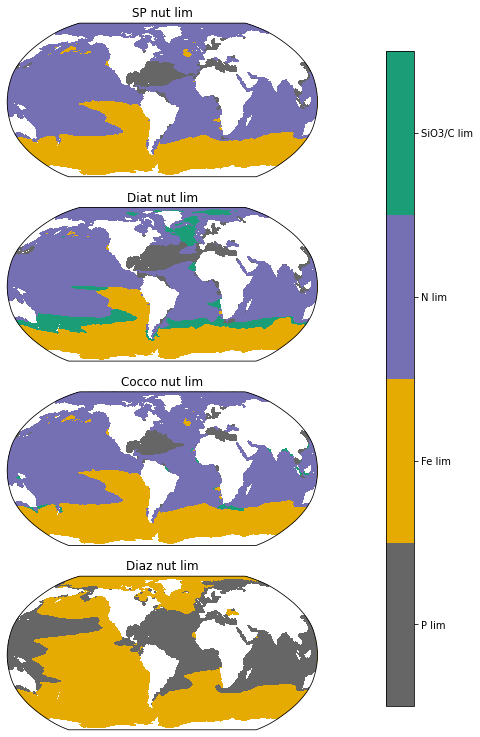

In [33]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
field = most_lim_diat.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
field = most_lim_sp.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco nut lim', fontsize=12)
field = most_lim_cocco.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
field = most_lim_diaz.where(~mask)
pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Monthly nutrient limitations

In [34]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_mon_ds2.sp_P_lim_surf, cesm_mon_ds2.sp_Fe_lim_surf,cesm_mon_ds2.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_mon_ds2.diat_P_lim_surf, cesm_mon_ds2.diat_Fe_lim_surf, cesm_mon_ds2.diat_N_lim_surf, cesm_mon_ds2.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_mon_ds2.diaz_P_lim_surf, cesm_mon_ds2.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_mon_ds2.cocco_P_lim_surf, cesm_mon_ds2.cocco_Fe_lim_surf, cesm_mon_ds2.cocco_N_lim_surf, cesm_mon_ds2.cocco_C_lim_surf),dim='nutrient')

In [35]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()
mask = np.isnan(cesm_ann_ds2.sp_N_lim_surf.squeeze())

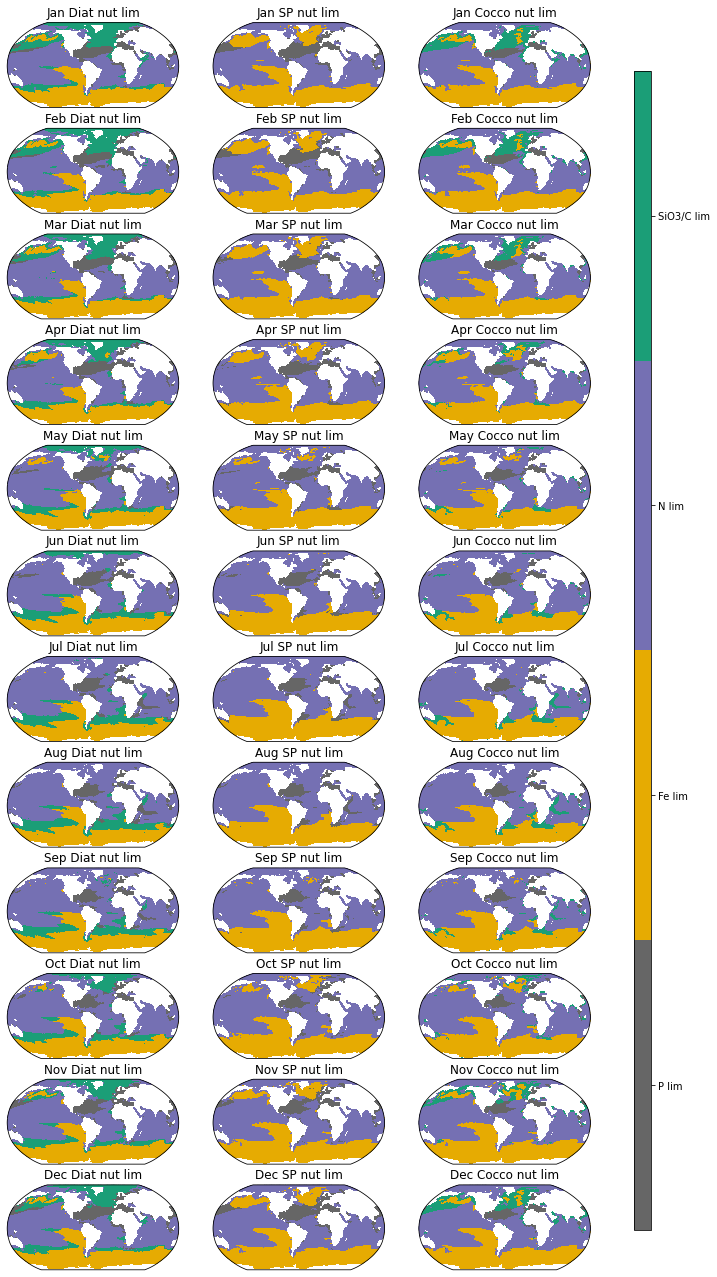

In [36]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' Diat nut lim', fontsize=12)
    field = most_lim_diat.isel(month=ts).where(~mask)
    pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' SP nut lim', fontsize=12)
    field = most_lim_sp.isel(month=ts).where(~mask)
    pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' Cocco nut lim', fontsize=12)
    field = most_lim_cocco.isel(month=ts).where(~mask)
    pc=ax.pcolormesh(lons, lats, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

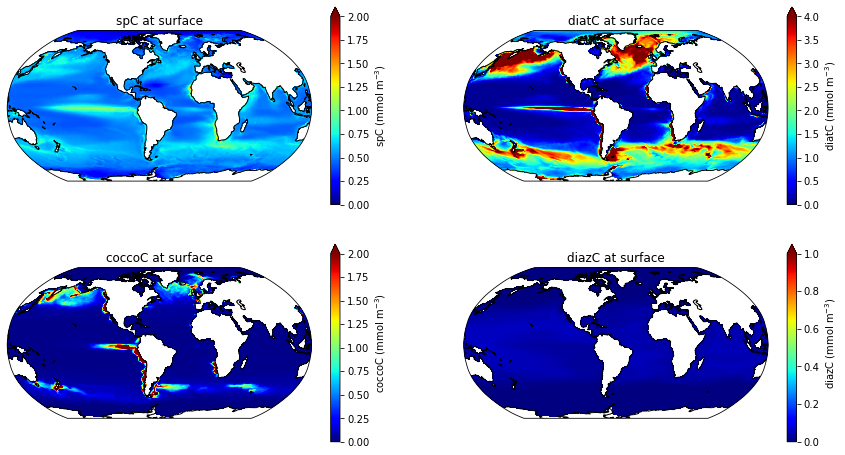

In [37]:
###### 
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoC.isel(z_l=0), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diatC.isel(z_l=0), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.spC.isel(z_l=0), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diazC.isel(z_l=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

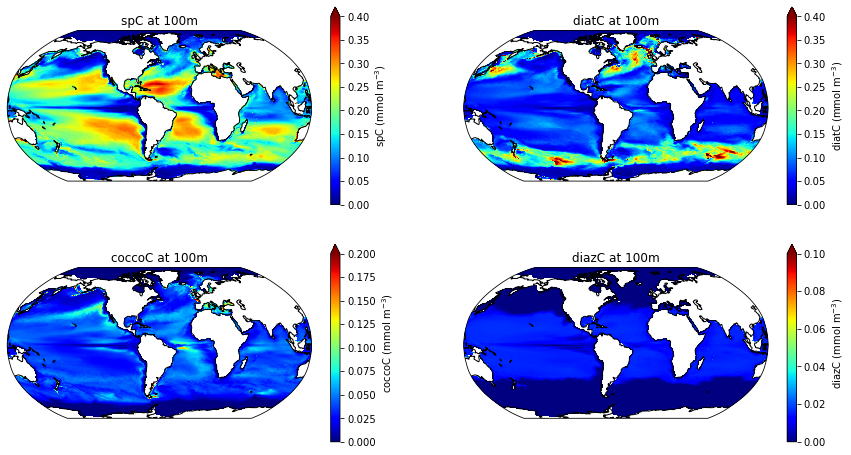

In [38]:
###### 
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diatC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.spC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diazC.isel(z_l=6), cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

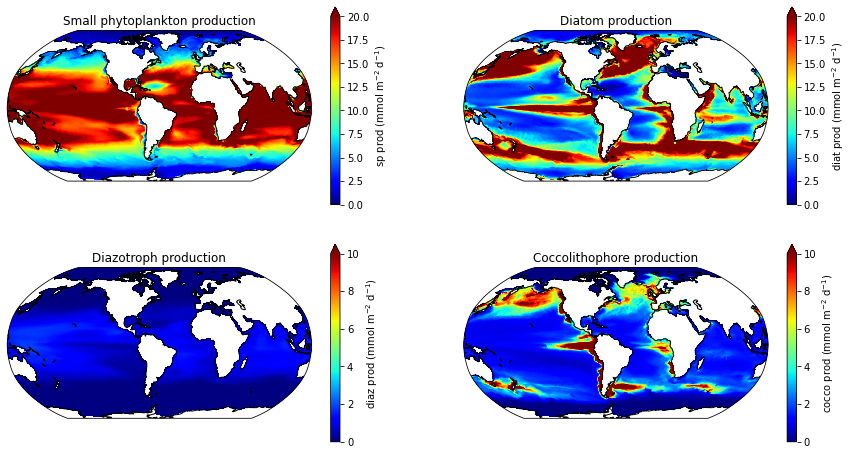

In [39]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = cesm_ann_ds2.photoC_sp_zint * 86400. #convert to mmol/m2/d
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=20,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = cesm_ann_ds2.photoC_diat_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=20,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = cesm_ann_ds2.photoC_diaz_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
tmp = cesm_ann_ds2.photoC_cocco_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)');

### Look at percent phytoC

In [40]:
phytoC = cesm_ann_ds.spC + cesm_ann_ds.diatC + cesm_ann_ds.diazC + cesm_ann_ds.coccoC
perc_sp = cesm_ann_ds.spC / (phytoC) * 100.
perc_cocco = cesm_ann_ds.coccoC / (phytoC) * 100.
perc_diat = cesm_ann_ds.diatC / (phytoC) * 100.
perc_diaz = cesm_ann_ds.diazC / (phytoC) * 100.

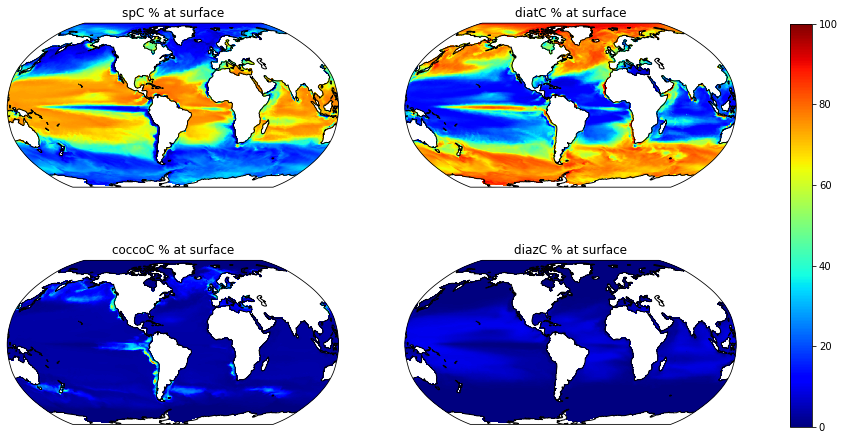

In [41]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=12)
field = perc_cocco.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
field = perc_diat.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
field = perc_sp.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
field = perc_diaz.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax);

### Plot zooC

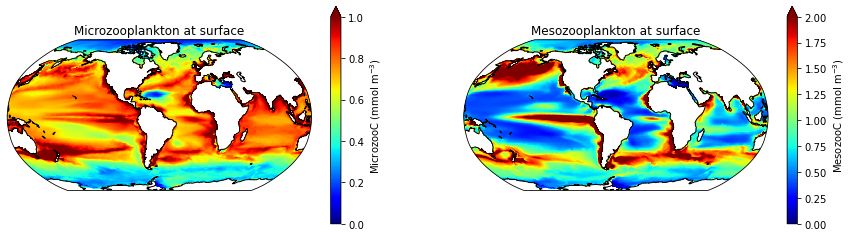

In [42]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton at surface', fontsize=12)
field = cesm_ann_ds.microzooC.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MicrozooC (mmol m$^{-3}$)')

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton at surface', fontsize=12)
field = cesm_ann_ds.mesozooC.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MesozooC (mmol m$^{-3}$)');


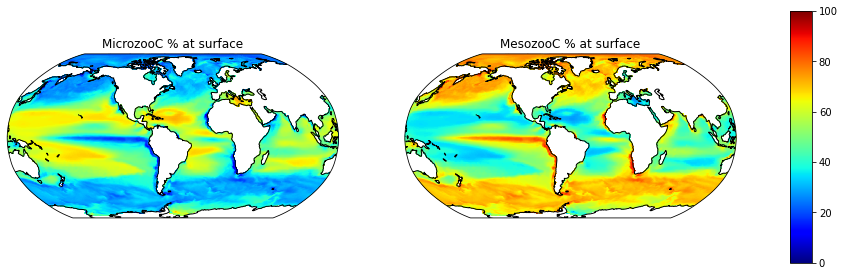

In [43]:
zooC = cesm_ann_ds.microzooC + cesm_ann_ds.mesozooC
perc_microzoo = cesm_ann_ds.microzooC / (zooC) * 100.
perc_mesozoo = cesm_ann_ds.mesozooC / (zooC) * 100.

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MicrozooC % at surface', fontsize=12)
field = perc_microzoo.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MesozooC % at surface', fontsize=12)
field = perc_mesozoo.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax);

### Sum zooplankton biomass to see how close we are to obs-based estimates

In [44]:
microzoo_biomass=  ((cesm_ann_ds.microzooC * area_depth).sum(dim=('xh', 'yh'))).compute() #mmol/m
microzoo_biomass = microzoo_biomass * dz #mmol
microzoo_biomass = microzoo_biomass.sum(dim='z_l')
microzoo_biomass = microzoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

print('Microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is ', np.round(microzoo_biomass,4), ' Pg C.')


mesozoo_biomass= ((cesm_ann_ds.mesozooC * area_depth).sum(dim=('xh', 'yh'))).compute() #mmol/m
mesozoo_biomass = mesozoo_biomass * dz #mmol
mesozoo_biomass = mesozoo_biomass.sum(dim='z_l')
mesozoo_biomass = mesozoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

print('Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013). Here it is ', np.round(mesozoo_biomass,4), ' Pg C.')

Microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is  0.2285  Pg C.
Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013). Here it is  0.3909  Pg C.


### Plot zooplankton production maps

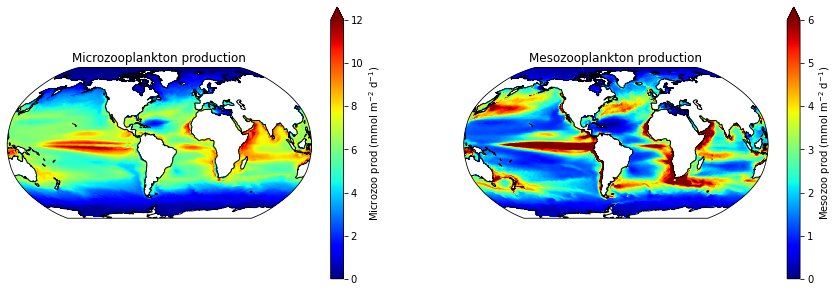

In [45]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton production', fontsize=12)
tmp = cesm_ann_ds2.x_graze_microzoo_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=12,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Microzoo prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton production', fontsize=12)
tmp = cesm_ann_ds2.x_graze_mesozoo_zint * 86400.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=6,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mesozoo prod (mmol m$^{-2}$ d$^{-1}$)')

## NPP - will add a map comparison to CbPM and VGPM soon!!

In [46]:
mmols_to_PgCyr = 1e-3 * 12. * 1e-15 * 365. * 86400.

In [47]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]
variables = variables + ['CaCO3_PROD_zint','POC_FLUX_100m']

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = ((cesm_ann_ds2[v] * area).sum(dim=('xh', 'yh'))).compute() #mmol/m
    ds_glb[v].attrs = cesm_ann_ds2[v].attrs

    ds_glb[v] = ds_glb[v] * mmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()


print('TOTAL       NPP = ', np.round(ds_glb.photoC_TOT_zint.values,3))
print('-------------------')
print('diatom      NPP = ', np.round(ds_glb.photoC_diat_zint.values,3))
print('small phyto NPP = ', np.round(ds_glb.photoC_sp_zint.values,3))
print('diaz        NPP = ', np.round(ds_glb.photoC_diaz_zint.values,3))
print('cocco       NPP = ', np.round(ds_glb.photoC_cocco_zint.values,3))

TOTAL       NPP =  49.949
-------------------
diatom      NPP =  19.796
small phyto NPP =  25.356
diaz        NPP =  0.956
cocco       NPP =  3.841


In [48]:
print('diatom NPP is ', np.round((ds_glb['photoC_diat_zint']/ds_glb['photoC_TOT_zint']*100.).values,2),'% of total NPP.')

diatom NPP is  39.63 % of total NPP.


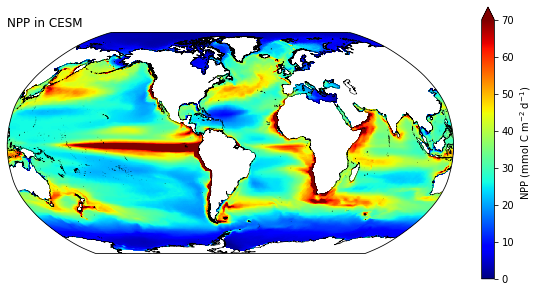

In [49]:
fig = plt.figure(figsize=(10,5))

import matplotlib.path as mpath
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP in CESM', loc='left')

ax.coastlines('10m',linewidth=0.5)
field = cesm_ann_ds2.photoC_TOT_zint*86400.

pc=ax.pcolormesh(lons, lats, field,
                 vmin=0, vmax=70, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol C m$^{-2}$ d$^{-1}$)');

## Chlorophyll comparison

In [50]:
chl_file = '/glade/work/kristenk/satellite_data/Chl_cumulative_mean/A20021852020182.L3m_CU_CHL_chlor_a_9km.nc'
ds_chl = xr.open_dataset(chl_file, decode_times=False)
#units are mg/m3
tot_chl = cesm_ann_ds.spChl.isel(z_l=0) + cesm_ann_ds.diatChl.isel(z_l=0) + cesm_ann_ds.coccoChl.isel(z_l=0) + cesm_ann_ds.diazChl.isel(z_l=0)

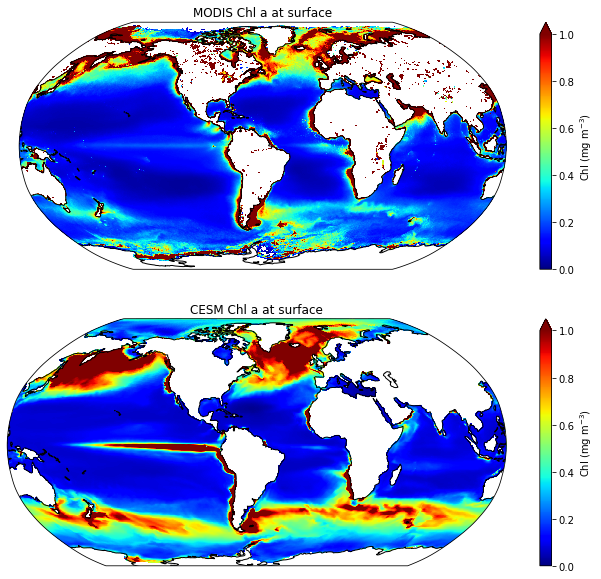

In [51]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(ds_chl.lon, ds_chl.lat, ds_chl.chlor_a, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(lons, lats, tot_chl, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


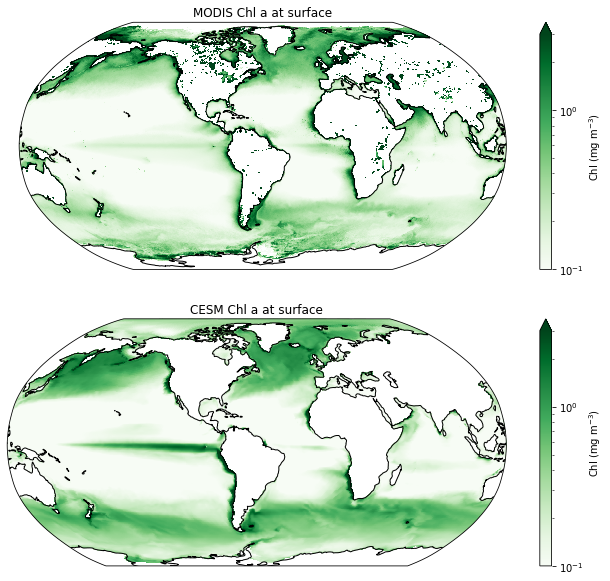

In [52]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(ds_chl.lon.values, ds_chl.lat.values, ds_chl.chlor_a, 
                 cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('110m',linewidth=1)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tot_chl)
pc=ax.pcolormesh(lon, lat, field,
                 cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


### Zooplankton production (zoo grazing - zoo respiration)
#### Should be ~25% of NPP

In [53]:
variables = [f'x_graze_{zoo}_zint' for zoo in ['microzoo', 'mesozoo']]

for v in variables:
    ds_glb[v] = ds_glb[v] = ((cesm_ann_ds2[v] * area).sum(dim=('xh', 'yh'))).compute() #mmol/m
    ds_glb[v].attrs = cesm_ann_ds2[v].attrs

    ds_glb[v] = ds_glb[v] * mmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:                ()
Data variables:
    photoC_diat_zint       float64 19.8
    photoC_sp_zint         float64 25.36
    photoC_diaz_zint       float64 0.9556
    photoC_cocco_zint      float64 3.841
    photoC_TOT_zint        float64 49.95
    CaCO3_PROD_zint        float64 1.313
    POC_FLUX_100m          float64 6.672
    x_graze_microzoo_zint  float64 8.124
    x_graze_mesozoo_zint   float64 4.075

In [54]:
## calculate % zoo prod of NPP 
npp_tot = ds_glb.photoC_TOT_zint.values
zoo_prod = ds_glb.x_graze_microzoo_zint.values + ds_glb.x_graze_mesozoo_zint.values
print('• Zooplankton production is ', (zoo_prod/npp_tot * 100.), '% of NPP.')
## calculate % microzooplankton (zoo1) prod of total zoo prod
micro_prod=ds_glb.x_graze_microzoo_zint.values
print('• Microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
print('• Microzooplankton production is ', (micro_prod/npp_tot * 100.), '% of NPP.')

• Zooplankton production is  24.424448877011795 % of NPP.
• Microzooplankton production is  66.5939590275142 % of total zooplankton production.
• Microzooplankton production is  16.265207477853387 % of NPP.


### Z-ratio (Stock & Dunne, 2010)

In [55]:
file = '/glade/work/kristenk/z-ratio/z_ratio_POPgrid2.nc'
ds_zratio = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [56]:
z_ratio = cesm_ann_ds2.x_graze_mesozoo_zint / cesm_ann_ds2.photoC_TOT_zint

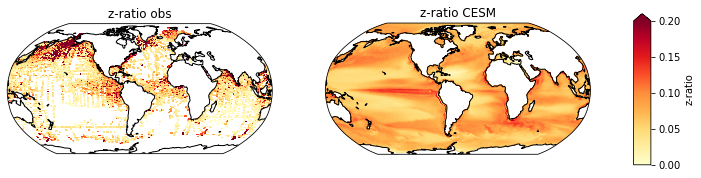

In [57]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio obs', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(ds_zratio.TLONG, ds_zratio.TLAT, ds_zratio.z_ratio)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio CESM', fontsize=12)
pc=ax.pcolormesh(lons, lats, z_ratio, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio');

### MAREDAT Micozooplankton/zoo1+zoo2 comparison

In [58]:
file = '/glade/work/kristenk/MAREDAT/microzooplankton/mean_fields/MAREDAT_microzoo_means.nc'
maredat_microzoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

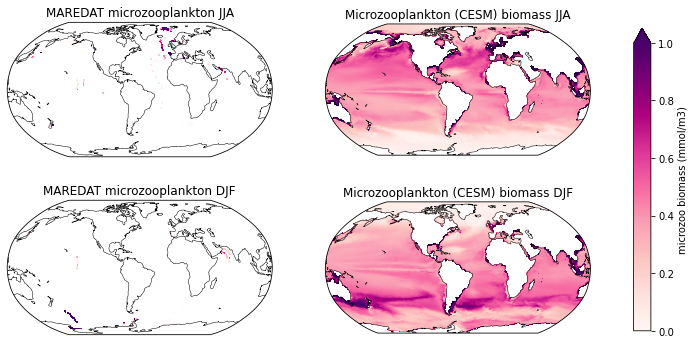

In [59]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton JJA', fontsize=12)
tmp = maredat_microzoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[5,6,7],z_l=slice(0,10)).mean(dim='z_l').mean(dim='month')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton DJF', fontsize=12)
tmp = maredat_microzoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[11,0,1],z_l=slice(0,10)).mean(dim='z_l').mean(dim='month')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max',label='microzoo biomass (mmol/m3)');

### COPEPOD comparison (Mesozooplankton)

In [60]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

In [61]:
cesm_ann_ds.z_l[9]

<xarray.DataArray 'z_l' ()>
array(200.)
Coordinates:
    z_l      float64 200.0
Attributes:
    units:      meters
    long_name:  Depth at cell center
    axis:       Z
    positive:   down
    edges:      z_i

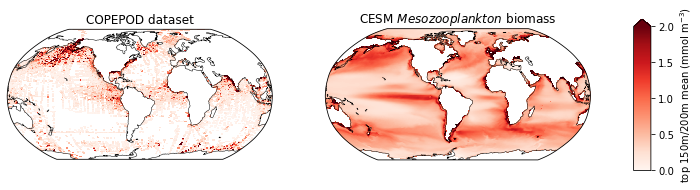

In [62]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(ds_zratio.TLONG, ds_zratio.TLAT,  ds_copepod.copepod_C)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
tmp = cesm_ann_ds.mesozooC.isel(z_l=slice(0,10)).mean(dim='z_l') #take mean just over the top 200m
pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)');

### compare to spatially interpolated COPEPOD climatology
#### (dataset is in units of mgC/m2, despite its being labeled otherwise, personal communication with Colleen Petrik)

In [63]:
file = '/glade/u/home/kristenk/work/copepod-biomass/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod_clim = xr.open_dataset(file)

In [64]:
ds_copepod_clim.zmeso200.attrs['units'] = 'mgC m-2'

### depth integrate CESM and convert to same units

In [65]:
### depth integrate and convert model to mol/m2
cesm_mon_ds['mesozooC_zint'] = ((cesm_mon_ds.mesozooC) * dz).sum(dim='z_l') #in mmol/m2
cesm_mon_ds['mesozooC_zint'] = cesm_mon_ds['mesozooC_zint'] * 12.011 #convert to mgC/m2
cesm_mon_ds['mesozooC_zint'].attrs['units'] = 'mgC m-2'

In [66]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

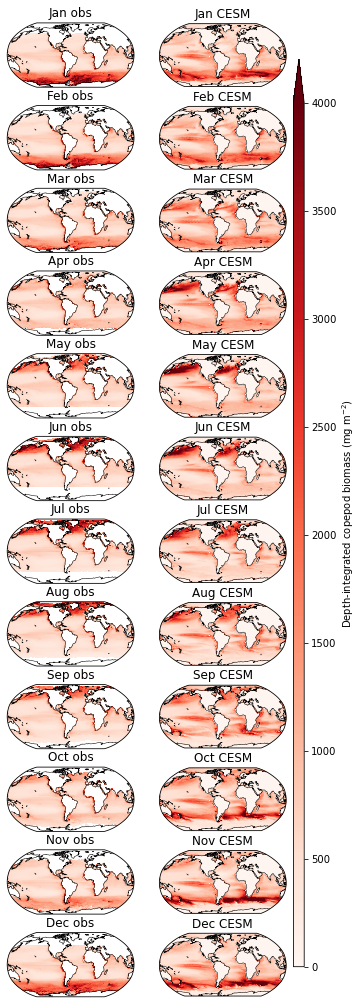

In [67]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' obs', fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), 
                     cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' CESM', fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(month=ts)
    pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mg m$^{-2}$)');

## Calcification

In [68]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
print('Globally integrated calcification is',np.round(ds_glb['CaCO3_PROD_zint'].values,4), 'Pg C per year')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 1.3125 Pg C per year
(should be between 0.6 to 2.4 Pg C per year)


In [69]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)

#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

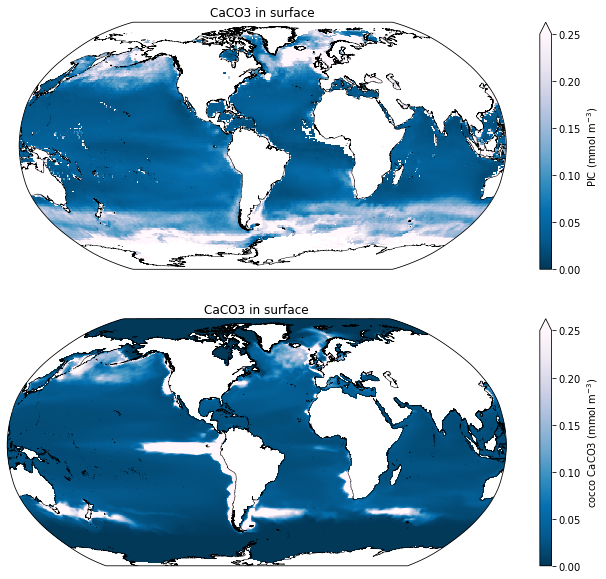

In [70]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='PIC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
field = cesm_ann_ds.coccoCaCO3.isel(z_l=0)
pc=ax.pcolormesh(lons, lats, field, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco CaCO3 (mmol m$^{-3}$)')


### cocco PIC/POC

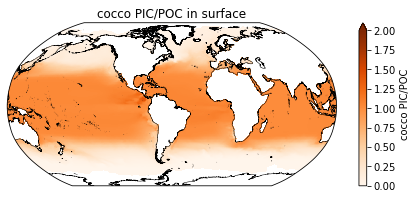

In [71]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('cocco PIC/POC in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
field = (cesm_ann_ds.coccoCaCO3.isel(z_l=0)/cesm_ann_ds.coccoC.isel(z_l=0)).where(cesm_ann_ds.coccoC.isel(z_l=0)>0.001)
pc=ax.pcolormesh(lons, lats, field, cmap='Oranges',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco PIC/POC')


## A few Antarctic views - will add a comparison to VGPM and CbPM obs soon!!

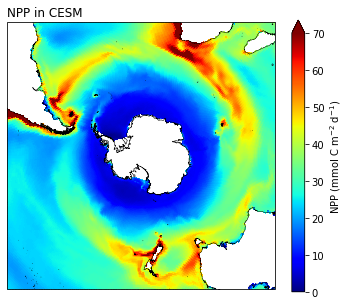

In [72]:
fig = plt.figure(figsize=(6,5))

import matplotlib.path as mpath
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP in CESM', loc='left')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
field = cesm_ann_ds2.photoC_TOT_zint*86400.

pc=ax.pcolormesh(lons, lats, field,
                 vmin=0, vmax=70, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol C m$^{-2}$ d$^{-1}$)');

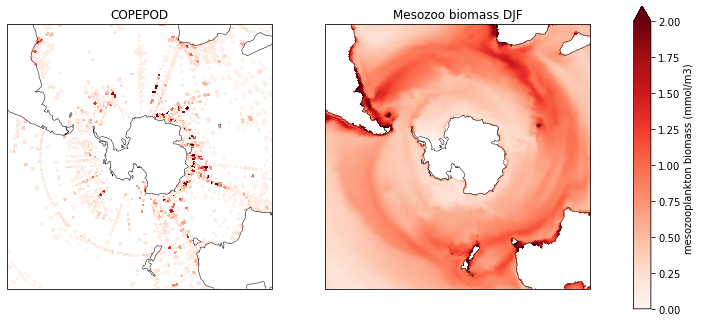

In [73]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('COPEPOD')
lon, lat, field = utils.adjust_pop_grid(ds_zratio.TLONG, ds_zratio.TLAT, ds_copepod.copepod_C)
pc=ax.pcolormesh(lon, lat, field, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################

ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Mesozoo biomass DJF', fontsize=12)
tmp = cesm_ann_ds.mesozooC.isel(z_l=slice(0,10)).mean(dim='z_l') #take mean just over the top 200m
pc=ax.pcolormesh(lons, lats, tmp, 
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())


ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='mesozooplankton biomass (mmol/m3)');

## N fixation

In [74]:
#global integral
tmp = (cesm_ann_ds['diaz_Nfix'] * area_depth).sum(dim=('xh', 'yh')).compute() #mmol/m
ds_glb['diaz_Nfix'] = (tmp * dz).sum(dim='z_l') #mmol
ds_glb['diaz_Nfix'] = ds_glb['diaz_Nfix'] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
ds_glb['diaz_Nfix'].values
print('Globally integrated marine nitrogen fixation is',np.round(ds_glb['diaz_Nfix'].values,4), 'Tg N per year')
print('(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)')

Globally integrated marine nitrogen fixation is 162.4806 Tg N per year
(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)


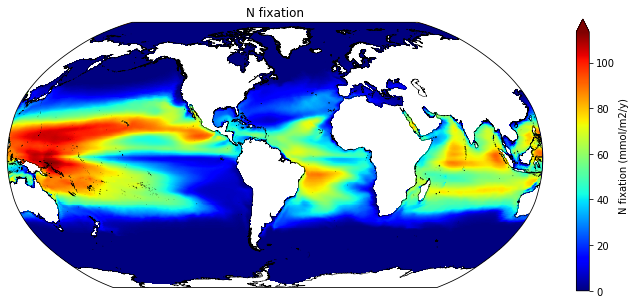

In [75]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('N fixation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
field = (cesm_ann_ds['diaz_Nfix']*dz).sum(dim='z_l').where(ds_grid.wet==1) * 86400. * 365.
pc=ax.pcolormesh(lons, lats, field, cmap='jet',
                 #vmin=0,vmax=2,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='N fixation (mmol/m2/y)')


## Alkalinity

In [76]:
#just getting this for the coords (that don't have nans)
path = '/glade/work/kristenk/GLODAPv2_regridded/'
files =[path+'TAlk_GLODAP_normal1deg_33depths.nc', path+'salinity_GLODAP_normal1deg_33depths.nc']
ds_glodap = xr.open_mfdataset(files, decode_times=False, decode_coords=False)

In [77]:
ds_glodap.depth_surface

<xarray.DataArray 'depth_surface' (depth_surface: 33)>
array([   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,  200.,
        250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
       1200., 1300., 1400., 1500., 1750., 2000., 2500., 3000., 3500., 4000.,
       4500., 5000., 5500.])
Coordinates:
  * depth_surface  (depth_surface) float64 0.0 10.0 20.0 ... 5e+03 5.5e+03
Attributes:
    long_name:  depth
    units:      m
    positive:   down

In [78]:
### Salinity normalized ALK
ds_glodap['sAlk'] = ds_glodap.TAlk/ds_glodap.salinity * 35.

In [81]:
cesm_ann_ds['sAlk'] = cesm_ann_ds.ALK/cesm_ann_ds.so * 35.

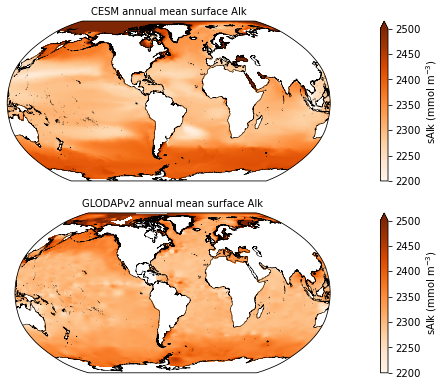

In [82]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

# #---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.sAlk.isel(z_l=0))
pc1=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('GLODAPv2 annual mean surface Alk', fontsize=10)
field = ds_glodap.sAlk.isel(depth_surface=0)
pc2=ax.pcolormesh(ds_glodap.lon, ds_glodap.lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

# #---- DIFF panel
# sALK_diff = cesm_ann_ds.sAlk - ds_glodap.sAlk

# ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
# ax.coastlines('10m',linewidth=0.5)
# ax.set_title('Surface Alk model bias', fontsize=10)
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  sALK_diff.isel(z_t=0))
# pc3=ax.pcolormesh(lon, lat, 
#                  field, vmin=-50, vmax=50, cmap='bwr',
#                  transform=ccrs.PlateCarree())
# cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='sAlk bias (mmol m$^{-3}$)')

## Global POC export

In [83]:
print('Globally integrated POC flux is',np.round(ds_glb['POC_FLUX_100m'].values,3), 'Pg C per year')

Globally integrated POC flux is 6.672 Pg C per year


### Export ratio

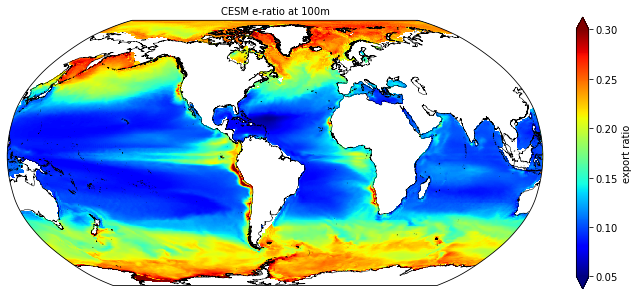

In [84]:
#plot E-RATIO
eratio = cesm_ann_ds2.POC_FLUX_100m/cesm_ann_ds2.photoC_TOT_zint

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM e-ratio at 100m', fontsize=10)
field = eratio
pc1=ax.pcolormesh(lons, lats, 
                 field, cmap='jet',
                  vmin=0.05, vmax=0.3, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='export ratio')


## Iron distributions

In [21]:
mmolm3_to_nM = 1e3
cesm_ann_ds['Fe'] = cesm_ann_ds['Fe'] * mmolm3_to_nM
cesm_ann_ds['Fe'].attrs['units'] = 'nM'

In [22]:
dFe_obs_file = '/glade/u/home/kristenk/cesm2-marbl/notebooks/discrete_obs/dFe-database-2021-05-20.csv'
df = pd.read_csv(dFe_obs_file, na_values=-999.).dropna(axis=0, how='all')

In [23]:
df

lon      lat   depth   dFe_obs
0      210.010 -16.0018    20.0  0.540000
1      210.010 -16.0018    35.0  0.440000
2      210.010 -16.0019    50.0  0.480000
3      210.010 -16.0019    80.0  0.400000
4      210.010 -16.0020   100.0  0.390000
...        ...      ...     ...       ...
27777  160.051  47.0032  3929.6  0.825681
27778  160.051  47.0032  3929.8  0.902248
27779  160.051  47.0032  4900.4  0.555630
27780  160.051  47.0032  4900.9  0.621851
27781  160.051  47.0032  5210.1  0.573220

[27782 rows x 4 columns]

In [24]:
### was trying to make 100 mean average - will revisit this later
#((cesm_ann_ds['Fe'] * dz).isel(z_l=slice(0,7)).sum(dim='z_l')/100).plot()

### Plot iron at surface - will make other depths later

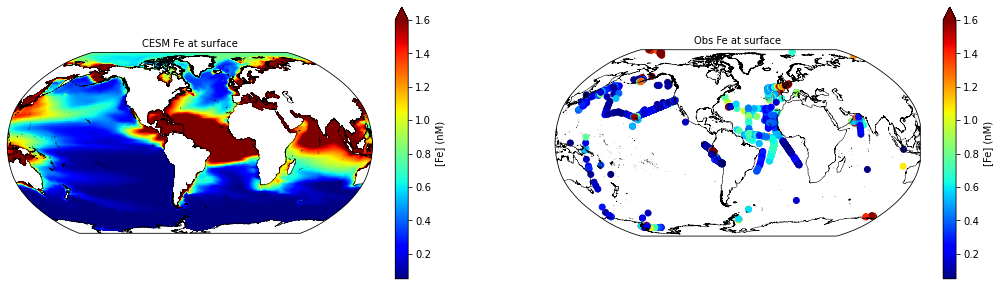

In [27]:
fig = plt.figure(figsize=(18,5))

##### top 100m

### CESM
ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM Fe at surface', fontsize=10)

field = cesm_ann_ds['Fe'].isel(z_l=0)
pc1=ax.pcolormesh(lons, lats, 
                 field, cmap='jet',
                  vmin=0.05, vmax=1.6, 
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='[Fe] (nM)')

### obs
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Obs Fe at surface', fontsize=10)


df_sub = df.loc[(df.depth <= 2.5)]
sc = ax.scatter(df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap='jet',
                vmin=0.05, vmax=1.6, 
                transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(sc, ax=ax,extend='max',label='[Fe] (nM)')

In [28]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
